In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 18:22:52) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=8, micro=6, releaselevel='final', serial=0)


## Introduction

Quantization has been shown to give 2-4x reduction in model size and as much as have an increase in model throughput. However, quantization also has been linked to significant degradation of model accuracy. By using model equalization, engineers are able to amiliorate the concerns of quantized model accuracy degradation at no expense to the optimizations of model size and throughput.

This tutorial shows how to preserve model accuracy through cross layer equalization, as well as how to perform either data-free model quantization or calibrated model quantization. This quantization functionality has recently been enabled in ONNX Runtime, allowing for significant performance gains on processors with AVX-512 VNNI instructions or similar quantization optimized hardware.

The process of quantization has a few steps, which includes: 

0. Import Modules, 
1. Define Data Loader, 
2. Export Model to ONNX, 
3. Equalize Model, 
4. Quantize Model, 
5. Validation Inference, and 
6. Final Results. 

We will be converting a model from, and do data loading with, PyTorch. These steps can also be done from any other ONNX supported framework.

## 0. Import Modules

This tutorial involves a few libraries. There uses are as follows:
- onnx and onnxruntime are used for model loading and inference. 
- torch and torchvision are used for data loading (with multi-process image preprocessing)
- numpy is used to store model results
- sklearn.metrics enables calculations such as accuracy, precision, recall, F1 score, etc.
- matplotlib is used to create the bar plots displaying the resulting metrics

Note the version of onnx and onnxruntime used to make this notebook possible.

In [2]:
# Model and Inference
import onnx
import onnx.numpy_helper
import onnxruntime
import onnxruntime.quantization

# Data Loader
import torch
import torchvision

# Evaluation
import numpy as np
import sklearn.metrics

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Other Utilities
import os
import pandas as pd
from tqdm import tqdm


print("onnx", onnx.__version__)
print("onnxruntime", onnxruntime.__version__)

onnx 1.8.0
onnxruntime 1.5.2


We will also use the model referenced in the original paper on [Data-Free Quantization Through Weight Equalization and Bias Correction](https://arxiv.org/abs/1906.04721). The MobileNetV2 model is authored by Ji Lin, [whose repository is linked here](https://github.com/tonylins/pytorch-mobilenet-v2).

In [3]:
if not os.path.exists("pytorch_mobilenet_v2"):
    import git
    git_path = "https://github.com/tonylins/pytorch-mobilenet-v2.git"
    git.Git().clone(git_path)
    
    os.rename("pytorch-mobilenet-v2", "pytorch_mobilenet_v2")

import pytorch_mobilenet_v2.MobileNetV2

## 1. Define Data Loader

The data source used for this tutorial is ImageNet, which is described by image-net.org as:

> ImageNet is an image database organized according to the WordNet hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images.

The original source is larger than necessary for pedagogy, so we will use a sample of 1,000 training and 1,000 validation images (one image for each class). The data used is provided by PyTorch and is linked here.

> https://s3.amazonaws.com/pytorch-tutorial-assets/imagenet_1k.zip

In [4]:
TRAIN_DATA_PATH = '/Users/jkonan/OneDrive - Intel Corporation/Data/imagenet_1k/train'
TEST_DATA_PATH = '/Users/jkonan/OneDrive - Intel Corporation/Data/imagenet_1k/val'

For pre-processing, the dataset class and dataloader class are both provided by Ji Lin. There are four pre-processing steps for validation:

1. Resizing the image to have width 256 and height 256,
2. Cropping the center of the image to have 224 width and 224 height,
3. Converting the image to a pytorch tensor (required for dataloading),
4. Normalizing the image using the mean and standard of all imagenet training.

The final input size to the model is (batch_size, number of channels, height, width) = (1, 3, 224, 224).

In [5]:
batch_size, in_channels, input_size = 1, 3, 224
n_worker = 8

imagenet_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(int(input_size/0.875)),
    torchvision.transforms.CenterCrop(input_size),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std =[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(
    TRAIN_DATA_PATH, 
    imagenet_transforms
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size, 
    num_workers=n_worker
)

val_dataset = torchvision.datasets.ImageFolder(
    TEST_DATA_PATH, 
    imagenet_transforms
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size, 
    num_workers=n_worker
)

example_train_input = next(iter(train_loader))[0]
example_val_input = next(iter(val_loader))[0]

print("Details of the training dataset and data loader are below.\n")
print("Num Observations: {}\nNum Batches:\t  {}\nBatch Shape:\t  {}\nNum Classes:\t  {}".\
      format(len(train_dataset), len(train_loader), list(example_train_input.shape), len(train_dataset.classes)))

print("\n\nDetails of the validation dataset and data loader are below.\n")
print("Num Observations: {}\nNum Batches:\t  {}\nBatch Shape:\t  {}\nNum Classes:\t  {}".\
      format(len(val_dataset), len(val_loader), list(example_val_input.shape), len(val_dataset.classes)))

Details of the training dataset and data loader are below.

Num Observations: 1000
Num Batches:	  1000
Batch Shape:	  [1, 3, 224, 224]
Num Classes:	  1000


Details of the validation dataset and data loader are below.

Num Observations: 1000
Num Batches:	  1000
Batch Shape:	  [1, 3, 224, 224]
Num Classes:	  1000


For QLinearOps, we will need a custom data reader class with a `get_next` attribute function. This is a modification to the PyTorch dataloader, which returns batches as a tuple of tensors versus the data reader returning batches as a dictionary with clearly labeled input name.

In [6]:
class data_reader:
    def __init__(self, loader, input_name="input"):
        self.reader = iter([{input_name:data[0].numpy()} for data in loader])
    
    def get_next(self):
        return next(self.reader, None)

---

## 2. Export Model to ONNX

There are six model versions of interest, each specified by a path. This includes...

- `ONNX_MODEL_PATH`, the original baseline float32 model;
- `QI_ONNX_MODEL_PATH`, the dynamic quantized QIntegerOps uint8 baseline model;
- `QL_ONNX_MODEL_PATH`, the static quantized QLinearOps uint baseline model;
- `E_ONNX_MODEL_PATH`, the float32 equalized model;
- `QI_E_ONNX_MODEL_PATH`, the dynamic quantized QIntegerOps uint8 baseline model;
- `QL_E_ONNX_MODEL_PATH`, the static quantized QLinearOps uint baseline model.

In [7]:
MODEL_PATH = "models"
MODEL_NAME = "mobilenet_v2"

ONNX_MODEL_PATH = MODEL_PATH + "/" + MODEL_NAME + ".onnx"
QI_ONNX_MODEL_PATH = MODEL_PATH + "/" + "QI-" + MODEL_NAME + ".onnx"
QL_ONNX_MODEL_PATH = MODEL_PATH + "/" + "QL-" + MODEL_NAME + ".onnx"

E_ONNX_MODEL_PATH = MODEL_PATH + "/" + "E-" + MODEL_NAME + ".onnx"
QI_E_ONNX_MODEL_PATH = MODEL_PATH + "/" + "QI-E-" + MODEL_NAME + ".onnx"
QL_E_ONNX_MODEL_PATH = MODEL_PATH + "/" + "QL-E-" + MODEL_NAME + ".onnx"

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
print("Equalized\tIntegerOps\tLinearOps\tPath")
print("    False\t     False\t    False\t", ONNX_MODEL_PATH, sep="")
print("    False\t      True\t    False\t", QI_ONNX_MODEL_PATH, sep="")
print("    False\t     False\t     True\t", QL_ONNX_MODEL_PATH, sep="")
print("     True\t     False\t    False\t", E_ONNX_MODEL_PATH, sep="")
print("     True\t      True\t    False\t", QI_E_ONNX_MODEL_PATH, sep="")
print("     True\t     False\t     True\t", QL_E_ONNX_MODEL_PATH, sep="")

Equalized	IntegerOps	LinearOps	Path
    False	     False	    False	models/mobilenet_v2.onnx
    False	      True	    False	models/QI-mobilenet_v2.onnx
    False	     False	     True	models/QL-mobilenet_v2.onnx
     True	     False	    False	models/E-mobilenet_v2.onnx
     True	      True	    False	models/QI-E-mobilenet_v2.onnx
     True	     False	     True	models/QL-E-mobilenet_v2.onnx


#### Converting ReLU6 to ReLU

ReLU6 is not currently supported for onnxruntime quantization, so we convert ReLU6 to ReLU. This change in topology has been shown to have low affect on accuracy. Augmenting the model is also possible after the model is in onnx but requires custom scripts.

It is also worth noting the exported model opset, which is opset 12. The most recent opset is opset 12, and it is above the minimum supported opset version 11 that is required for quantization.

In [8]:
def convert_relu6_to_relu(model):
    for child_name, child in model.named_children():
        if isinstance(child, torch.nn.ReLU6):
            setattr(model, child_name, torch.nn.ReLU(inplace=True))
        else:
            convert_relu6_to_relu(child)

mobilenet_v2 = pytorch_mobilenet_v2.MobileNetV2.mobilenet_v2()
convert_relu6_to_relu(mobilenet_v2)
dummy_input = torch.ones(example_val_input.shape)

torch.onnx.export(mobilenet_v2,
                  dummy_input,
                  ONNX_MODEL_PATH,
                  input_names = ['input'],
                  output_names = ['output'],
                  opset_version=12)

onnx_model = onnx.load(ONNX_MODEL_PATH)
onnx.checker.check_model(onnx_model)

---

## 3. Equalize Model 

Cross layer equalization is applied using the equalize function we developed for onnx. The paper motivating this code is titled [Data-Free Quantization Through Weight Equalization and Bias Correction](https://arxiv.org/pdf/1906.04721.pdf). Internally, the equalization algorithm performs a few steps, which include:
1. Model Augmentation - Converting ReLU6 to ReLU, merging batch normalization, and removing unused nodes.
2. Defining Iterable Set - Chosing which pairs of nodes to equalize between (in order).
3. Executing Iterations - Applying layer equalization to each pair of the iterable set and updating both weights and biases.

Because network topologies vary based on their origin, it is recommended that users of this function use onnx opset 12. Further, modifications may be necessary for either converting to ReLU, merge batch normalization, or any other augmentation necessary to simplify the model into only conv, batchnorm, and add ops.

These three steps and their doc strings can be found in equalization.py.

In [9]:
import equalization

equalized_onnx_model = equalization.equalize(ONNX_MODEL_PATH)

onnx.save(equalized_onnx_model,
          E_ONNX_MODEL_PATH)

---

## 4. Quantize Model

Quantization is done in ONNX Runtime using its [onnx quantization tool](https://github.com/microsoft/onnxruntime/tree/master/onnxruntime/python/tools/quantization). The doc strings of the arguments needed for quantization are worth quoting here at length. Verbatim, quantization requires the following:
- param `model_input`: file path of model to quantize
- param `model_output`: file path of quantized model
- param `calibration_data_reader`: a calibration data reader. It enumerates calibration data and generates inputs for the original model.
- param `op_types_to_quantize`: specify the types of operators to quantize, like ['Conv'] to quantize Conv only. It quantizes all supported operators by default.
- param `op_types`: operators to quantize
- param `per_channel`: quantize weights per channel
- param `reduce_range`: quantize weights with 7-bits. It may improve the accuracy for some models running on non-VNNI machine, especially for per-channel mode
- param `activation_type`: quantization data type of activation
- param `weight_type`: quantization data type of weight
- param `nodes_to_quantize`: List of nodes names to quantize. When this list is not None only the nodes in this list are quantized. example:
        ```
        [
            'Conv__224',
            'Conv__252'
        ]
        ```
-  param `nodes_to_exclude`: List of nodes names to exclude. The nodes in this list will be excluded from quantization
        when it is not None.
-  parma `use_external_data_format`: option used for large size (>2GB) model. Set to False by default. 

### 4a. Quantize Model (IntegerOps)

Models quantized using IntegerOps have their quantization parameters calculated dynamically and result in an int8 onnx model. Models derived under dynamic regimes do not need any additional data to compute. For this reason, these models are considered "data-free" quantized models. 

The relevant code for quantizing the baseline model using IntegerOps is as follows:

In [10]:
kwargs = {"op_types_to_quantize":     [],
          "per_channel":              False,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_dynamic(ONNX_MODEL_PATH, 
                                          QI_ONNX_MODEL_PATH, 
                                          **kwargs)

#### IntegerOps Model Size Reduction

We see that the baseline quantized using IntegerOps results in an approximate 50% reduction in model size. This is to be expected, and similar model sizes will be observed in subsequent experiments.

In [11]:
onnx_size_mb   = os.path.getsize(ONNX_MODEL_PATH)/1e6
qi_onnx_size_mb = os.path.getsize(QI_ONNX_MODEL_PATH)/1e6

print("\nONNX model size (MB):     {:.2f}".format(onnx_size_mb))
print("\nQI-ONNX model size (MB):  {:.2f}".format(qi_onnx_size_mb))


ONNX model size (MB):     14.19

QI-ONNX model size (MB):  7.65


### 4b. Equalized and Quantized Model (IntegerOps)

Models first equalized follow the same quantize procedure as non-equalized models. In the case of IntegerOps, we take an equalized model then dynamically quantize it to create an int8 model. This procedure is still "data-free" because neither equalization nor dynamic quantization requires additional data.

The relevant code for quantizing the equalized model using IntegerOps is as follows:

In [12]:
kwargs = {"op_types_to_quantize":     [],
          "per_channel":              False,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_dynamic(E_ONNX_MODEL_PATH, 
                                          QI_E_ONNX_MODEL_PATH, 
                                          **kwargs)

In [13]:
e_onnx_size_mb   = os.path.getsize(E_ONNX_MODEL_PATH)/1e6
qi_e_onnx_size_mb = os.path.getsize(QI_E_ONNX_MODEL_PATH)/1e6

print("\nE-ONNX model size (MB):     {:.2f}".format(onnx_size_mb))
print("\nQI-E-ONNX model size (MB):  {:.2f}".format(qi_e_onnx_size_mb))


E-ONNX model size (MB):     14.19

QI-E-ONNX model size (MB):  7.75


### 4c. Quantize Model (QLinearOps)

Models quantized using QLinearOps have their quantization parameters calibrated for static use and result in an int8 onnx model. Models derived under static regimes require additional data to compute. QLinearOps is preferred for decreased model latency if the time and data for calibration is available.

The relevant code for quantizing the baseline model using QLinearOps is as follows:

In [14]:
train_data_reader = data_reader(train_loader)

kwargs = {"op_types_to_quantize":     [],
          "per_channel":              False,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_static(ONNX_MODEL_PATH, 
                                         QL_ONNX_MODEL_PATH, 
                                         train_data_reader,
                                         **kwargs)

if os.path.exists("./augmented_model.onnx"):
    os.remove("./augmented_model.onnx")

Calibrated,quantized parameters calculated and returned.


#### QLinearOps Model Size Reduction

As expected, we see that the baseline quantized using QLinearOps results in an approximate 50% reduction in model size.

In [15]:
onnx_size_mb   = os.path.getsize(ONNX_MODEL_PATH)/1e6
ql_onnx_size_mb = os.path.getsize(QL_ONNX_MODEL_PATH)/1e6

print("\nONNX model size (MB):     {:.2f}".format(onnx_size_mb))
print("\nQL-ONNX model size (MB):  {:.2f}".format(ql_onnx_size_mb))


ONNX model size (MB):     14.19

QL-ONNX model size (MB):  7.65


### 4d. Equalized and Quantized Model (QLinearOps)

Similarly, models equalized then quantized using QLinearOps follow the same procedure as non-equalized models. Though equalization is "data-free", when used in conjunction with QLinearOps the procedure is no longer "data-free." If you are considering QLinearOps, equalization is recommended because the affected model will likely see less of an accuracy drop.

The relevant code for quantizing the equalized model using QLinearOps is as follows:

In [16]:
train_data_reader = data_reader(train_loader)

kwargs = {"op_types_to_quantize":     [],
          "per_channel":              False,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_static(E_ONNX_MODEL_PATH, 
                                         QL_E_ONNX_MODEL_PATH, 
                                         train_data_reader,
                                         **kwargs)

if os.path.exists("./augmented_model.onnx"):
    os.remove("./augmented_model.onnx")

Calibrated,quantized parameters calculated and returned.


#### QLinearOps Model Size Reduction

As expected, we see that the baseline quantized using QLinearOps results in an approximate 50% reduction in model size.

In [17]:
e_onnx_size_mb   = os.path.getsize(E_ONNX_MODEL_PATH)/1e6
ql_e_onnx_size_mb = os.path.getsize(QL_E_ONNX_MODEL_PATH)/1e6

print("\nE-ONNX model size (MB):     {:.2f}".format(e_onnx_size_mb))
print("\nQI-E-ONNX model size (MB):  {:.2f}".format(ql_e_onnx_size_mb))


E-ONNX model size (MB):     14.26

QI-E-ONNX model size (MB):  7.72


## 5. Validation Inference

For inference, we define a few helper functions. They include methods for setting up an ONNX Runtime inference session, calculating loss, calculating latency, and reporting results. Validation performs inference on the validation set, and, at the end of the loop, its predictions are used for metric calculation.

In [18]:
class init_inference:
    def __init__(self, session):
        self.session = session
        
    def __call__(self, image):
        input_data = image.numpy()
        input_name  = self.session.get_inputs()[0].name
    
        return self.session.run(None, {input_name: input_data})

def Xent(logits, labels):
    logits = torch.tensor(logits[0])
    loss_fn = torch.nn.CrossEntropyLoss()
    
    return float(loss_fn(logits, labels))

def mean_latency_fn(tqdm_dataloader):
    start = tqdm_dataloader.start_t
    stop = tqdm_dataloader.last_print_t
    n = tqdm_dataloader.n
    
    mean_latency = (stop - start)/n
    
    return mean_latency

def simple_table(data_multilist, x_label_list, y_label_list):
    for i in range(len(y_label_list)+1):
        if i == 0:
            row = ["\t"]
            row.extend(x_label_list)
            string = "\t".join(row)
        else:
            row = [y_label_list[i-1]]
            
            row.extend([format(x, ".6f") for x in data_multilist[i-1]])
            string = "\t".join(row)
            
        print(string)
        
    return None

def plot_statistic(x, y, title, x_label, y_label):

    label_pos = [i for i, _ in enumerate(x)]

    plt.figure(figsize=(12, 6))
    plt.bar(label_pos, x, color='black', width=0.8)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(label_pos, y)
    
    plt.show()
    
    return None

def validate(dataloader, session):
    tqdm_dataloader = tqdm(dataloader)
    inference = init_inference(session)
    loss_labels, pred_labels, true_labels = [], [], []

    for idx, (images, target) in enumerate(tqdm_dataloader):
        
        logits = inference(images)
        labels = np.argmax(logits[0][0])
        loss   = Xent(logits, target)

        pred_labels.append(labels)
        true_labels.append(int(target))
        loss_labels.append(loss + 1e-6)
        
    mean_latency = mean_latency_fn(tqdm_dataloader)

    return loss_labels, pred_labels, true_labels, mean_latency

### 5a. Validate Baseline Model

In [19]:
ort_session = onnxruntime.InferenceSession(ONNX_MODEL_PATH)

loss_labels, pred_labels, true_labels, mean_latency =\
    validate(val_loader, ort_session)

100%|██████████| 1000/1000 [00:40<00:00, 24.62it/s]


### 5b. Validate Equalized Model

In [20]:
e_ort_session = onnxruntime.InferenceSession(E_ONNX_MODEL_PATH)

e_loss_labels, e_pred_labels, e_true_labels, e_mean_latency =\
    validate(val_loader, e_ort_session)

100%|██████████| 1000/1000 [00:39<00:00, 25.34it/s]


### 5c. Validate Baseline IntegerOps Model

In [21]:
qi_ort_session = onnxruntime.InferenceSession(QI_ONNX_MODEL_PATH)

qi_loss_labels, qi_pred_labels, qi_true_labels, qi_mean_latency =\
    validate(val_loader, qi_ort_session)

100%|██████████| 1000/1000 [02:10<00:00,  7.63it/s]


### 5d. Validate Equalized IntegerOps Model

In [22]:
qi_e_ort_session = onnxruntime.InferenceSession(QI_E_ONNX_MODEL_PATH)

qi_e_loss_labels, qi_e_pred_labels, qi_e_true_labels, qi_e_mean_latency =\
    validate(val_loader, qi_e_ort_session)

100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


### 5e. Validate Baseline QLinearOps Model

In [23]:
ql_ort_session = onnxruntime.InferenceSession(QL_ONNX_MODEL_PATH)

ql_loss_labels, ql_pred_labels, ql_true_labels, ql_mean_latency =\
    validate(val_loader, ql_ort_session)

100%|██████████| 1000/1000 [02:03<00:00,  8.07it/s]


### 5f. Validate Equalized QLinearOps Model

In [24]:
ql_e_ort_session = onnxruntime.InferenceSession(QL_E_ONNX_MODEL_PATH)

ql_e_loss_labels, ql_e_pred_labels, ql_e_true_labels, ql_e_mean_latency =\
    validate(val_loader, ql_e_ort_session)

100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


## 6. Final Results

The final results include four metrics: latency, loss, accuracy, and model size. 
- **Latency** gives us an idea of how long on average it takes to do inference on an image. 
- **Loss** tells us precicely how much our model's predicted logits differ from the expected class. 
- **Accuracy** tells us how often the most likely predicted class is consistent with the expected class. 
- **Model size** gives us an idea of the memory bandwidth required to perform inference.

### 6a. Model Inference Latency

Though quantization has theoretical performance improvements, we see that some systems (such as the one this experiment is ran on) cannot always benifit from these gains. In particular, AVX-512 VNNI instructions enable lower latencies, which this system cannot benifit from. However, it is still worth noting how QLinearOps is relatively faster to IntegerOps, though quantization is not recommended on a system such as this.

In [25]:
# print('Validation latency results are below.\n')

# simple_table(
#     data_multilist = [[mean_latency,      e_mean_latency   ],
#                       [qi_mean_latency,   qi_e_mean_latency],
#                       [ql_e_mean_latency, ql_e_mean_latency]], 
#     x_label_list = ["Baseline", "Equalized"], 
#     y_label_list = ["float32 ", "IntegerOps", "QLinearOps"]
# )

In [26]:
# x = [mean_latency, e_mean_latency, qi_mean_latency, qi_e_mean_latency, ql_mean_latency, ql_e_mean_latency]
# y = ['Baseline-fp32', 'Equalized-fp32', 'Baseline-IOps', 'Equalized-IOps', 'Baseline-LOps', 'Equalized-LOps']
# title = "MobileNetV2 Latency Results"
# x_label = "Model Type"
# y_label = "Mean Latency (sec)"

# plot_statistic(x, y, title, x_label, y_label)

### 6b. Model Inference Cross Entropy Loss

Below, it is apparent that quantized models adversely affect logit calculation and result in a higher loss. Though QLinearOps is faster than Integer Ops (as seen above), this higher speed is accompanied with less precise logits. Engineers are encouraged to weigh the tradeoffs between these two models, and to also consider the later reported accuracy results.

In [27]:
mean_loss      = np.mean(loss_labels)
e_mean_loss    = np.mean(e_loss_labels)
qi_mean_loss   = np.mean(qi_loss_labels)
qi_e_mean_loss = np.mean(qi_e_loss_labels)
ql_mean_loss   = np.mean(ql_loss_labels)
ql_e_mean_loss = np.mean(ql_e_loss_labels)

print('Validation loss results are below.\n')

simple_table(
    data_multilist = [[mean_loss,    e_mean_loss   ],
                      [qi_mean_loss, qi_e_mean_loss],
                      [ql_mean_loss, ql_e_mean_loss]],
    x_label_list = ["Baseline", "Equalized"],
    y_label_list = ["float32 ", "IntegerOps", "QLinearOps"]
)

Validation loss results are below.

		Baseline	Equalized
float32 	1.112608	1.112607
IntegerOps	2.430798	1.886650
QLinearOps	3.679957	2.367664


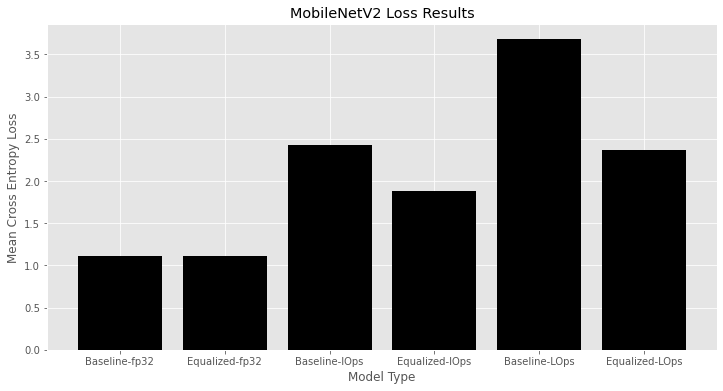

In [28]:
x = [mean_loss, e_mean_loss, qi_mean_loss, qi_e_mean_loss, ql_mean_loss, ql_e_mean_loss]
y = ['Baseline-fp32', 'Equalized-fp32', 'Baseline-IOps', 'Equalized-IOps', 'Baseline-LOps', 'Equalized-LOps']
title = "MobileNetV2 Loss Results"
x_label = "Model Type"
y_label = "Mean Cross Entropy Loss"
    
plot_statistic(x, y, title, x_label, y_label)

### 6c. Model Inference Accuracy

Below, we see that, without equalization, IntegerOps takes a significant model hit of over 20% and QLinearOps takes an even greater hit of over 40%. Equalization ameliorates the accuracy degradation caused by quantization, with IntegerOps and QLinearOps seeing less than 5% and 10% accuracy drop, respectively.

In [29]:
accuracy_score      = sklearn.metrics.accuracy_score(true_labels, pred_labels)
e_accuracy_score    = sklearn.metrics.accuracy_score(e_true_labels, e_pred_labels)
qi_accuracy_score   = sklearn.metrics.accuracy_score(qi_true_labels, qi_pred_labels)
qi_e_accuracy_score = sklearn.metrics.accuracy_score(qi_e_true_labels, qi_e_pred_labels)
ql_accuracy_score   = sklearn.metrics.accuracy_score(ql_true_labels, ql_pred_labels)
ql_e_accuracy_score = sklearn.metrics.accuracy_score(ql_e_true_labels, ql_e_pred_labels)

print('Validation accuracy results are below.\n')

simple_table(
    data_multilist = [[accuracy_score,    e_accuracy_score   ] ,
                      [qi_accuracy_score, qi_e_accuracy_score] ,
                      [ql_accuracy_score, ql_e_accuracy_score]],
    x_label_list = ["Baseline", "Equalized"],
    y_label_list = ["float32 ", "IntegerOps", "QLinearOps"]
)

Validation accuracy results are below.

		Baseline	Equalized
float32 	0.726000	0.726000
IntegerOps	0.480000	0.578000
QLinearOps	0.303000	0.498000


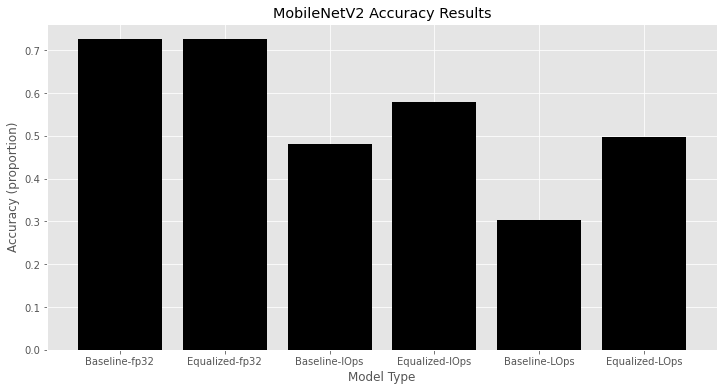

In [30]:
x = [accuracy_score, e_accuracy_score, qi_accuracy_score, qi_e_accuracy_score, ql_accuracy_score, ql_e_accuracy_score]
y = ['Baseline-fp32', 'Equalized-fp32', 'Baseline-IOps', 'Equalized-IOps', 'Baseline-LOps', 'Equalized-LOps']
title = "MobileNetV2 Accuracy Results"
x_label = "Model Type"
y_label = "Accuracy (proportion)"
    
plot_statistic(x, y, title, x_label, y_label)

### 6d. Model Inference F1 Score

For comparison, results of the F1 score are included. The behavior is similar to what was observed in the accuracy calculation. 

In [31]:
f1_score      = sklearn.metrics.f1_score(true_labels, pred_labels, average="weighted")
e_f1_score    = sklearn.metrics.f1_score(e_true_labels, e_pred_labels, average="weighted")
qi_f1_score   = sklearn.metrics.f1_score(qi_true_labels, qi_pred_labels, average="weighted")
qi_e_f1_score = sklearn.metrics.f1_score(qi_e_true_labels, qi_e_pred_labels, average="weighted")
ql_f1_score   = sklearn.metrics.f1_score(ql_true_labels, ql_pred_labels, average="weighted")
ql_e_f1_score = sklearn.metrics.f1_score(ql_e_true_labels, ql_e_pred_labels, average="weighted")

print('Validation accuracy results are below.\n')

simple_table(
    data_multilist = [[f1_score,    e_f1_score   ] ,
                      [qi_f1_score, qi_e_f1_score] ,
                      [ql_f1_score, ql_e_f1_score]],
    x_label_list = ["Baseline", "Equalized"],
    y_label_list = ["float32 ", "IntegerOps", "QLinearOps"]
)

Validation accuracy results are below.

		Baseline	Equalized
float32 	0.668333	0.668333
IntegerOps	0.410075	0.507652
QLinearOps	0.253002	0.433317


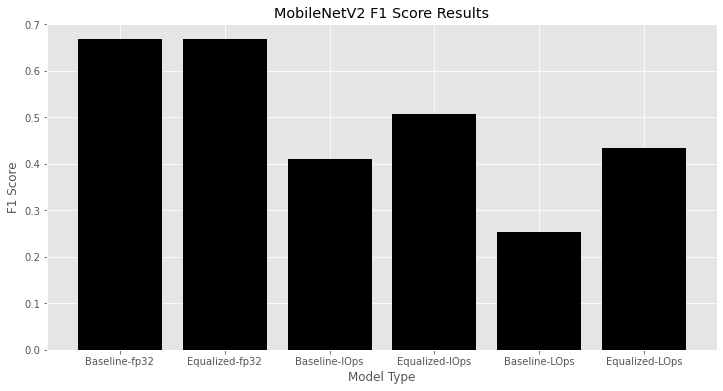

In [32]:
x = [f1_score, e_f1_score, qi_f1_score, qi_e_f1_score, ql_f1_score, ql_e_f1_score]
y = ['Baseline-fp32', 'Equalized-fp32', 'Baseline-IOps', 'Equalized-IOps', 'Baseline-LOps', 'Equalized-LOps']
title = "MobileNetV2 F1 Score Results"
x_label = "Model Type"
y_label = "F1 Score"
    
plot_statistic(x, y, title, x_label, y_label)

### 6e. Model Size

Below, with and without equalization, we see that model sizes are reduced by quantization. The size reduction is similar between IntegerOps and QLinearOps.

In [33]:
print('Model sizes are below.\n')

simple_table(
    data_multilist = [[onnx_size_mb,    e_onnx_size_mb   ] ,
                      [qi_onnx_size_mb, qi_e_onnx_size_mb] ,
                      [ql_onnx_size_mb, ql_e_onnx_size_mb]],
    x_label_list = ["Baseline", "Equalized"],
    y_label_list = ["float32 ", "IntegerOps", "QLinearOps"]
)

Model sizes are below.

		Baseline	Equalized
float32 	14.186708	14.258113
IntegerOps	7.648918	7.751473
QLinearOps	7.646638	7.724481


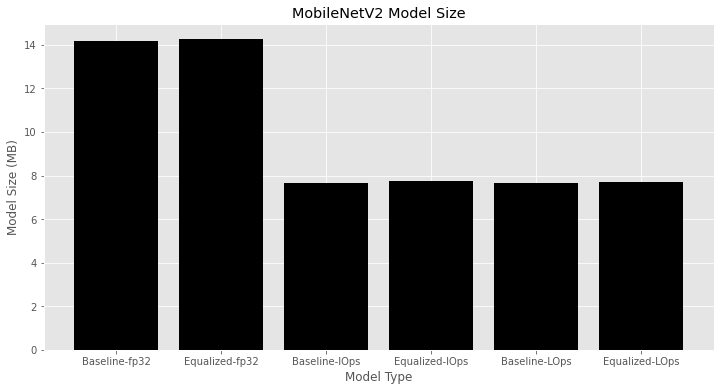

In [34]:
x = [onnx_size_mb, e_onnx_size_mb, qi_onnx_size_mb, qi_e_onnx_size_mb, ql_onnx_size_mb, ql_e_onnx_size_mb]
y = ['Baseline-fp32', 'Equalized-fp32', 'Baseline-IOps', 'Equalized-IOps', 'Baseline-LOps', 'Equalized-LOps']
title = "MobileNetV2 Model Size"
x_label = "Model Type"
y_label = "Model Size (MB)"
    
plot_statistic(x, y, title, x_label, y_label)

### Summary

#### Advantages of Equalization
- Large gains in accuracy in models with depthwise convolutions
- Future proof, theoretically shows gains in int6 (though not as large)
- It produces an optimized network, so you can stack other techniques
- Data-free quantization technique, which only needs the network to function

#### Challenges and Limitations
- The algorithm is designed for simplified topologies (Conv, BN, ReLU)
- Some models already seeing high accuracy see only marginal benifit (e.g. ResNet)

#### Future Work and Improvements
- Testing equalization in an environment with int4 capabilities
- Needs to be tested on additional models to become more robust to errors
- Bias Correction is also suggested in the original paper, with 1-3% gains

## Appendix

Below are details of the system information and packages used to generate the results in this notebook. 

In [35]:
import cpuinfo # !conda install -c conda-forge py-cpuinfo
cpuinfo.get_cpu_info()

{'python_version': '3.8.6.final.0 (64 bit)',
 'cpuinfo_version': [7, 0, 0],
 'cpuinfo_version_string': '7.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 8,
 'arch_string_raw': 'AMD64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz',
 'hz_advertised_friendly': '1.9000 GHz',
 'hz_actual_friendly': '1.4080 GHz',
 'hz_advertised': [1900000000, 0],
 'hz_actual': [1408000000, 0],
 'l2_cache_size': 1048576,
 'stepping': 12,
 'model': 142,
 'family': 6,
 'l3_cache_size': 8388608,
 'flags': ['3dnow',
  '3dnowprefetch',
  'abm',
  'acpi',
  'adx',
  'aes',
  'apic',
  'avx',
  'avx2',
  'bmi1',
  'bmi2',
  'clflush',
  'clflushopt',
  'cmov',
  'cx16',
  'cx8',
  'de',
  'dtes64',
  'dts',
  'erms',
  'est',
  'f16c',
  'fma',
  'fpu',
  'fxsr',
  'ht',
  'hypervisor',
  'ia64',
  'invpcid',
  'lahf_lm',
  'mca',
  'mce',
  'mmx',
  'movbe',
  'mpx',
  'msr',
  'mtrr',
  'osxsave',
  'pae',
  'pat',
  'pbe',
  'pcid',
  'pclmulqdq',
  'pdcm',
  'pge',

In [36]:
conda list

# packages in environment at C:\Users\jkonan\Anaconda3:
#
Note: you may need to restart the kernel to use updated packages.

# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
anaconda-client           1.7.2                      py_0    conda-forge
anaconda-navigator        1.10.0                   py38_0  
argon2-cffi               20.1.0           py38h294d835_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     20.3.0             pyhd3deb0d_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.1                      py_0    conda-forge
beautifulsoup4            4.9.3              pyhb0f4dca_0    conda-forge
blas                      2.21                        mkl    conda-forge
bleach                    3

In [37]:
pip freeze

jedi                      0.17.2           py38haa244fe_1    conda-forge
jinja2                    2.11.2             pyh9f0ad1d_0    conda-forge
joblib                    0.17.0                   pypi_0    pypi
jpeg                      9d                   h8ffe710_0    conda-forge
json5                     0.9.5              pyh9f0ad1d_0    conda-forge
jsonschema                3.2.0                      py_2    conda-forge
jupyter_client            6.1.7                      py_0    conda-forge
jupyter_contrib_core      0.3.3                      py_2    conda-forge
jupyter_contrib_nbextensions 0.5.1            py38h32f6830_1    conda-forge
jupyter_core              4.7.0            py38haa244fe_0    conda-forge
jupyter_highlight_selected_word 0.2.0           py38h32f6830_1002    conda-forge
jupyter_latex_envs        1.4.6           py38h32f6830_1001    conda-forge
jupyter_nbextensions_configurator 0.4.1            py38h32f6830_2    conda-forge
jupyterlab                2.2.9      

anaconda-client==1.7.2
anaconda-navigator==1.10.0
argon2-cffi @ file:///D:/bld/argon2-cffi_1605217273648/work
async-generator==1.10
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1601745390275/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1600454382015/work
brotlipy==0.7.0
Cerberus==1.3.2
certifi==2020.11.8
cffi @ file:///D:/bld/cffi_1602537433319/work
chardet @ file:///D:/bld/chardet_1602255508636/work
click==7.1.2
clyent==1.2.2
cmake==3.18.2.post1
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1602866480661/work
conda==4.9.2
conda-build==3.20.5
conda-package-handling @ file:///D:/bld/conda-package-handling_1602877082869/work
conda-verify @ file:///D:/bld/conda-verify_1603158504992/work
cryptograph